# TinyML
## Tensorflow Lite를 이용한 On-Device ML 추론

### Support Devices: https://www.tensorflow.org/lite/microcontrollers

### Work Flow
1. 리눅스 서버 상에서 Tensorflow 모델 학습
2. 학습한 Tensorflow 모델을 TFLite 모델 변환
    - FP16 or INT8 Quantization 적용
3. TFLite 모델 파일을 C Source 변환
    - 리눅스 xxd 유틸리티 사용
4. 변환된 모델 파일을 사용하는 Target App 개발
    - C/C++
    - TFLite Interpreter
5. Cross Compile 하여 바이너리 실행 파일 생성
6. 바이너리 타일을 Target Device에 배포

## Enviroment Setup

- x86_64-linux-gnu
- Ubuntu 22.04.1 LTS
- gcc version 11.3.0
- python 3.10.6
- tensorflow 2.11.0

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

MODELS_DIR = 'models/'
os.makedirs(MODELS_DIR, exist_ok=True)
MODEL_TF = os.path.join(MODELS_DIR, 'model')
MODEL_TFLITE = os.path.join(MODELS_DIR, 'model.tflite')
MODEL_TFLITE_MICRO = os.path.join(MODELS_DIR, 'model.cc')

print(MODEL_TF)              # Tensorflow 모델 경로
print(MODEL_TFLITE)          # TFLite 모델 경로
print(MODEL_TFLITE_MICRO)    # MCU 디바이스를 위한 모델 경로

models/model
models/model.tflite
models/model.cc


In [2]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

# 실험 재현을 위해 시드값 설정
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)

## 리눅스 서버 상에서 Tensorflow 모델 학습

0~2π 사이의 Sine wave를 예측하는 신경망 학습

1. 데이터셋 생성
2. 데이터셋 분할 - Train / Validation / Test
3. 학습
4. 성능 측정

## 데이터셋 생성

1. 랜덤한 X값 생성
2. 그에 대한 Sine값 계산
3. 계산된 Sine값에 대해 Noise 추가

In [3]:
# 데이터 개수
SAMPLES = 1000

# x_values: 0 to 2π 사이의 값 uniform 분포로 샘플링 
x_values = np.random.uniform(low=0, high=2*math.pi, size=SAMPLES).astype(np.float32)
np.random.shuffle(x_values)

# x값에 대한 사인 값 계산
y_values = np.sin(x_values).astype(np.float32)

print(x_values.shape)
print(x_values[:5])

print(y_values.shape)
print(y_values[:5])

(1000,)
[3.5250568 3.3671365 3.320874  3.4734828 5.3714824]
(1000,)
[-0.37413532 -0.22363645 -0.17832246 -0.32583064 -0.7905478 ]


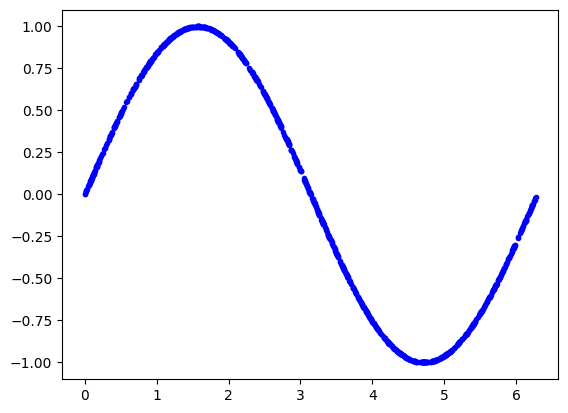

In [4]:
# Plot Data 
# 'b.' => blue dot
plt.plot(x_values, y_values, 'b.')
plt.show()

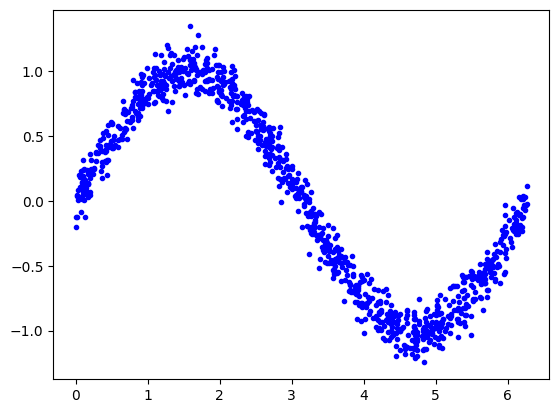

In [5]:
# y값에 작은 noise 추가
y_values += 0.1 * np.random.randn(y_values.shape[0])

# Plot Data
plt.plot(x_values, y_values, 'b.')
plt.show()

## 데이터셋 분할

1. Training: 60%
2. Validation: 20%
3. Testing: 20%

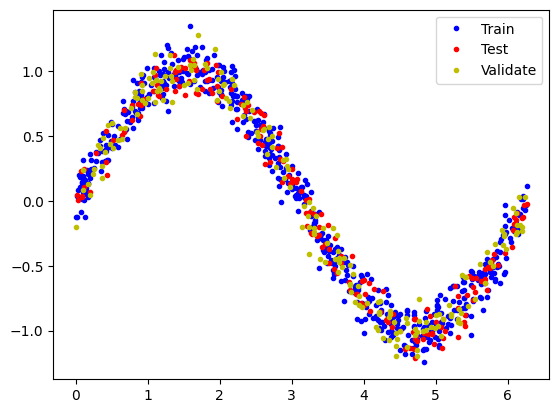

In [6]:
# We'll use 60% of our data for training and 20% for testing. The remaining 20%
# will be used for validation. Calculate the indices of each section.
TRAIN_SPLIT =  int(0.6 * SAMPLES)
TEST_SPLIT = int(0.2 * SAMPLES + TRAIN_SPLIT)

# Use np.split to chop our data into three parts.
# The second argument to np.split is an array of indices where the data will be
# split. We provide two indices, so the data will be divided into three chunks.
x_train, x_test, x_validate = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_test, y_validate = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])

# Double check that our splits add up correctly
assert (x_train.size + x_validate.size + x_test.size) ==  SAMPLES

# Plot the data in each partition in different colors:
plt.plot(x_train, y_train, 'b.', label="Train")
plt.plot(x_test, y_test, 'r.', label="Test")
plt.plot(x_validate, y_validate, 'y.', label="Validate")
plt.legend()
plt.show()

## 학습
1. 2 레이어 FC 신경망 생성
2. 생성한 데이터셋으로 모델 학습
3. 학습 Epoch별 MSE, MAE Plot

In [7]:
# 2 레이어 FC 신경망 생성
model = tf.keras.Sequential()

model.add(keras.layers.Dense(16, activation='relu', input_shape=(1,)))
model.add(keras.layers.Dense(16, activation='relu'))

# 출력 레이어, 1개 값 출력
model.add(keras.layers.Dense(1))

# 회귀를 위한 MSE Loss
# Adam Optimizer
model.compile(optimizer='adam', loss="mse", metrics=["mae"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                32        
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Tensorflow 모델 학습
history = model.fit(x_train, y_train, epochs=512, batch_size=64, validation_data=(x_validate, y_validate), verbose=0)

# Tensorflow 모델 저장
model.save(MODEL_TF)

INFO:tensorflow:Assets written to: models/model/assets


In [9]:
!ls -R models

models:
model

models/model:
assets	fingerprint.pb	keras_metadata.pb  saved_model.pb  variables

models/model/assets:

models/model/variables:
variables.data-00000-of-00001  variables.index


## 성능 측정

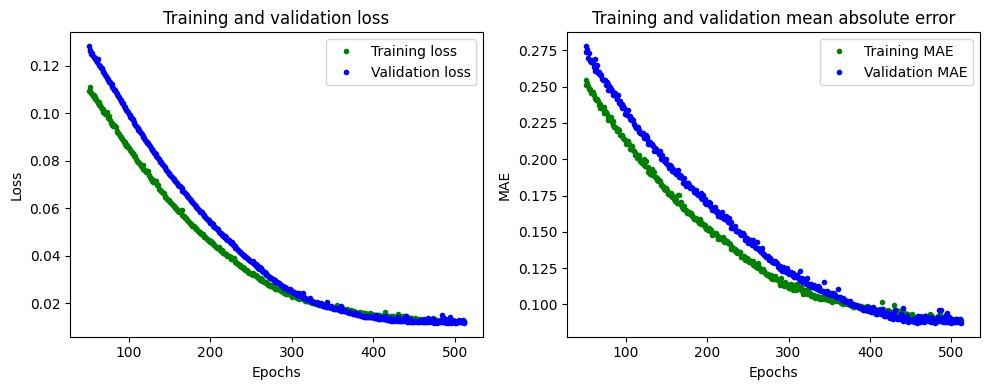

In [10]:
# Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

# Exclude the first few epochs so the graph is easier to read
SKIP = 50

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)

plt.plot(epochs[SKIP:], train_loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)

# Draw a graph of mean absolute error, which is another way of
# measuring the amount of error in the prediction.
train_mae = history.history['mae']
val_mae = history.history['val_mae']

plt.plot(epochs[SKIP:], train_mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()

7/7 [==============================] - 0s 676us/step


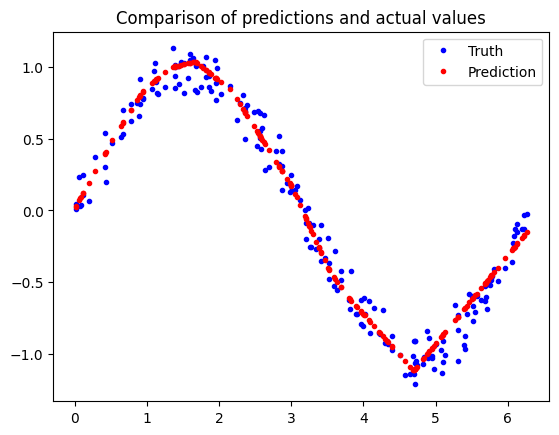

In [11]:
# Calculate and print the loss on our test dataset
test_loss, test_mae = model.evaluate(x_test, y_test)

# Make predictions based on our test dataset
y_test_pred = model.predict(x_test)

# Graph the predictions against the actual values
plt.clf()
plt.title('Comparison of predictions and actual values')
plt.plot(x_test, y_test, 'b.', label='Truth')
plt.plot(x_test, y_test_pred, 'r.', label='Prediction')
plt.legend()
plt.show()

# 학습한 Tensorflow 모델을 TFLite 모델 변환

1. TFLite 모델 변환
2. Tensorflow 모델 vs TFLite 모델 예측 비교

## TFLite 모델 변환

In [12]:
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_TF)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
# TFLite Int8 Quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

def representative_dataset():
    for i in range(500):
        yield([x_train[i].reshape(1, 1)])
converter.representative_dataset = representative_dataset

# TFLite Model로 변환
model_tflite = converter.convert()

fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8


In [13]:
# TFLite 모델 저장
open(MODEL_TFLITE, "wb").write(model_tflite)

2664

In [14]:
def predict_tflite(tflite_model, x_test):
    # Prepare the test data
    x_test_ = x_test.copy()
    x_test_ = x_test_.reshape((x_test.size, 1))
    x_test_ = x_test_.astype(np.float32)

    # Initialize the TFLite interpreter
    interpreter = tf.lite.Interpreter(model_content=tflite_model)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    # If required, quantize the input layer (from float to integer)
    input_scale, input_zero_point = input_details["quantization"]
    if (input_scale, input_zero_point) != (0.0, 0):
        #breakpoint()  --> jupyter notebook - local
        x_test_ = x_test_ / input_scale + input_zero_point
        x_test_ = x_test_.astype(input_details["dtype"])

    # Invoke the interpreter
    y_pred = np.empty(x_test_.size, dtype=output_details["dtype"])
    for i in range(len(x_test_)):
        interpreter.set_tensor(input_details["index"], [x_test_[i]])
        interpreter.invoke()
        y_pred[i] = interpreter.get_tensor(output_details["index"])[0]

    # If required, dequantized the output layer (from integer to float)
    output_scale, output_zero_point = output_details["quantization"]
    if (output_scale, output_zero_point) != (0.0, 0):
        y_pred = y_pred.astype(np.float32)
        y_pred = (y_pred - output_zero_point) * output_scale

    return y_pred

## Tensorflow 모델 vs TFLite 모델 예측 비교

In [15]:
y_test_pred_tf = model.predict(x_test)
y_test_pred_tf = y_test_pred_tf.reshape(-1)

y_test_pred_tflite = predict_tflite(model_tflite, x_test)

7/7 [==============================] - 0s 692us/step


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


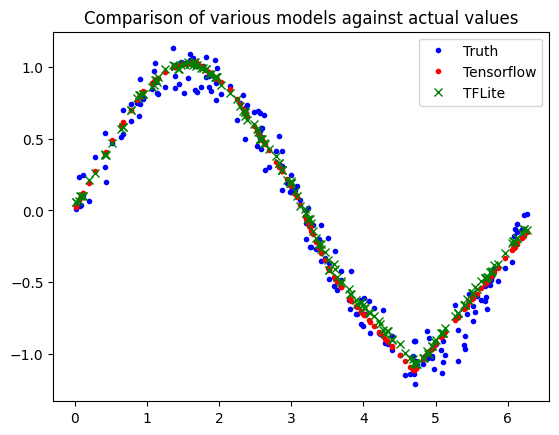

In [38]:
plt.clf()
plt.title('Comparison of various models against actual values')
plt.plot(x_test, y_test, 'bo', label='Truth')
plt.plot(x_test, y_test_pred_tf, 'ro', label='Tensorflow')
plt.plot(x_test, y_test_pred_tflite, 'gx', label='TFLite')
plt.legend()
plt.show()

In [17]:
mse = tf.keras.losses.MeanSquaredError()

loss_tf = mse(y_test, y_test_pred_tf).numpy()
loss_tflite = mse(y_test, y_test_pred_tflite).numpy()

pd.DataFrame.from_records(
    [["TensorFlow", loss_tf],
     ["TFLite", loss_tflite]],
    columns = ["Model", "Loss/MSE"], index="Model").round(4)

,Loss/MSE
Model,
TensorFlow,0.011
TFLite,0.012


## TFLite 모델 파일을 C Source 변환

In [18]:
# xxd: 파일 or 표준 입출력을 hex dump 하는 리눅스 표준 유틸리티
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}

In [19]:
!ls -R models

models:
model  model.cc  model.tflite

models/model:
assets	fingerprint.pb	keras_metadata.pb  saved_model.pb  variables

models/model/assets:

models/model/variables:
variables.data-00000-of-00001  variables.index


### 변환된 모델 파일 확인

In [20]:
!head -5 {MODEL_TFLITE_MICRO}
!echo ".................."
!tail -6 {MODEL_TFLITE_MICRO}

unsigned char models_model_tflite[] = {
  0x20, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x00, 0x00, 0x00, 0x00,
  0x14, 0x00, 0x20, 0x00, 0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00,
  0x0c, 0x00, 0x00, 0x00, 0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00,
  0x1c, 0x00, 0x00, 0x00, 0x90, 0x00, 0x00, 0x00, 0xe8, 0x00, 0x00, 0x00,
..................
  0x02, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x10, 0x00, 0x00, 0x00, 0x0c, 0x00, 0x10, 0x00,
  0x0f, 0x00, 0x00, 0x00, 0x08, 0x00, 0x04, 0x00, 0x0c, 0x00, 0x00, 0x00,
  0x09, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x09
};
unsigned int models_model_tflite_len = 2664;


## 변환된 모델 파일을 사용하는 Target App 개발

 - Tensorflow Lite 공식 example 사용

### Example 소스코드 확인

In [21]:
!ls tensorflow/tensorflow/lite/micro/examples/hello_world

BUILD			 esp			     output_handler.cc
Makefile.inc		 hello_world_binary_test.sh  output_handler.h
README.md		 hello_world_test.cc	     output_handler_test.cc
arduino			 images			     riscv32_mcu
constants.cc		 main.cc		     sparkfun_edge
constants.h		 main_functions.cc	     tags
create_sine_model.ipynb  main_functions.h	     train
cscope.out		 model.cc		     zephyr_riscv
disco_f746ng		 model.h


##### main.cc
tensorflow/tensorflow/lite/micro/examples/hello_world/main.cc

```cpp
#include "tensorflow/lite/micro/examples/hello_world/main_functions.h"

// This is the default main used on systems that have the standard C entry
// point. Other devices (for example FreeRTOS or ESP32) that have different
// requirements for entry code (like an app_main function) should specialize
// this main.cc file in a target-specific subfolder.

int main(int argc, char* argv[]) {
  setup();
  while (true) {
    loop();
  }
}
```

##### main_functions.c
tensorflow/tensorflow/lite/micro/examples/hello_world/main_functions.cc

setup()
 - hexdump로 선언된 모델코드를 tflite 모델로 객채화
 - 입력, 출력 메모리 allocation

```cpp
void setup() {
  // Set up logging. Google style is to avoid globals or statics because of
  // lifetime uncertainty, but since this has a trivial destructor it's okay.
  // NOLINTNEXTLINE(runtime-global-variables)
  static tflite::MicroErrorReporter micro_error_reporter;
  error_reporter = &micro_error_reporter;

  // Map the model into a usable data structure. This doesn't involve any
  // copying or parsing, it's a very lightweight operation.
  model = tflite::GetModel(g_model);
  if (model->version() != TFLITE_SCHEMA_VERSION) {
    TF_LITE_REPORT_ERROR(error_reporter,
                         "Model provided is schema version %d not equal "
                         "to supported version %d.",
                         model->version(), TFLITE_SCHEMA_VERSION);
    return;
  }

  // This pulls in all the operation implementations we need.
  // NOLINTNEXTLINE(runtime-global-variables)
  static tflite::AllOpsResolver resolver;

  // Build an interpreter to run the model with.
  static tflite::MicroInterpreter static_interpreter(
      model, resolver, tensor_arena, kTensorArenaSize, error_reporter);
  interpreter = &static_interpreter;

  // Allocate memory from the tensor_arena for the model's tensors.
  TfLiteStatus allocate_status = interpreter->AllocateTensors();
  if (allocate_status != kTfLiteOk) {
    TF_LITE_REPORT_ERROR(error_reporter, "AllocateTensors() failed");
    return;
  }

  // Obtain pointers to the model's input and output tensors.
  input = interpreter->input(0);
  output = interpreter->output(0);

  // Keep track of how many inferences we have performed.
  inference_count = 0;
}
```


##### main_functions.c
tensorflow/tensorflow/lite/micro/examples/hello_world/main_functions.cc

loop()
 - interpreter->invoke(): 모델 추론 실행
 - HandleOutput(): 추론 결과 출력

```cpp
void loop() {
  // Calculate an x value to feed into the model. We compare the current
  // inference_count to the number of inferences per cycle to determine
  // our position within the range of possible x values the model was
  // trained on, and use this to calculate a value.
  float position = static_cast<float>(inference_count) /
                   static_cast<float>(kInferencesPerCycle);
  float x = position * kXrange;

  // Quantize the input from floating-point to integer
  int8_t x_quantized = x / input->params.scale + input->params.zero_point;
  // Place the quantized input in the model's input tensor
  input->data.int8[0] = x_quantized;

  // Run inference, and report any error
  TfLiteStatus invoke_status = interpreter->Invoke();
  if (invoke_status != kTfLiteOk) {
    TF_LITE_REPORT_ERROR(error_reporter, "Invoke failed on x: %f\n",
                         static_cast<double>(x));
    return;
  }

  // Obtain the quantized output from model's output tensor
  int8_t y_quantized = output->data.int8[0];
  // Dequantize the output from integer to floating-point
  float y = (y_quantized - output->params.zero_point) * output->params.scale;

  // Output the results. A custom HandleOutput function can be implemented
  // for each supported hardware target.
  HandleOutput(error_reporter, x, y);

  // Increment the inference_counter, and reset it if we have reached
  // the total number per cycle
  inference_count += 1;
  if (inference_count >= kInferencesPerCycle) inference_count = 0;
}

```

##### model.cc
tensorflow/tensorflow/lite/micro/examples/hello_world/model.cc

```
#include "tensorflow/lite/micro/examples/hello_world/model.h"

// Keep model aligned to 8 bytes to guarantee aligned 64-bit accesses.
alignas(8) const unsigned char g_model[] = {
    0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00,
    0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00, 0x0c, 0x00, 0x00, 0x00,
    0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00,
    0x98, 0x00, 0x00, 0x00, 0xc8, 0x00, 0x00, 0x00, 0x1c, 0x03, 0x00, 0x00,
    0x2c, 0x03, 0x00, 0x00, 0x30, 0x09, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
    ......
    0x01, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x24, 0x00, 0x00, 0x00,
    0x73, 0x65, 0x72, 0x76, 0x69, 0x6e, 0x67, 0x5f, 0x64, 0x65, 0x66, 0x61,
    0x75, 0x6c, 0x74, 0x5f, 0x64, 0x65, 0x6e, 0x73, 0x65, 0x5f, 0x32, 0x5f,
    0x69, 0x6e, 0x70, 0x75, 0x74, 0x3a, 0x30, 0x5f, 0x69, 0x6e, 0x74, 0x38,
    0x00, 0x00, 0x00, 0x00, 0x02, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00,
    0x00, 0x00, 0x00, 0x09};
const int g_model_len = 2488;
```

### Target App 개발
1. 생성한 모델 model.cc 파일에 적용
2. 0~2π 사이의 200개의 값에 대해 추론하도록 수정

model.cc 파일 수정 
 - hexdump로 생성한 모델 파일 copy & paste
 
```cpp
#include "tensorflow/lite/micro/examples/hello_world/model.h"

// Keep model aligned to 8 bytes to guarantee aligned 64-bit accesses.
alignas(8) const unsigned char g_model[] = {
  0x20, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x00, 0x00, 0x00, 0x00,
  0x14, 0x00, 0x20, 0x00, 0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00,
  0x0c, 0x00, 0x00, 0x00, 0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00,
  0x1c, 0x00, 0x00, 0x00, 0x90, 0x00, 0x00, 0x00, 0xe8, 0x00, 0x00, 0x00,
  0xa4, 0x03, 0x00, 0x00, 0xb4, 0x03, 0x00, 0x00, 0x0c, 0x0a, 0x00, 0x00,
  ......
  0x65, 0x5f, 0x69, 0x6e, 0x70, 0x75, 0x74, 0x3a, 0x30, 0x00, 0x00, 0x00,
  0x02, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x10, 0x00, 0x00, 0x00, 0x0c, 0x00, 0x10, 0x00,
  0x0f, 0x00, 0x00, 0x00, 0x08, 0x00, 0x04, 0x00, 0x0c, 0x00, 0x00, 0x00,
  0x09, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x09
};
const int g_model_len = 2664;

```

main.cc 파일 수정
```cpp
#include "tensorflow/lite/micro/examples/hello_world/main_functions.h"

// This is the default main used on systems that have the standard C entry
// point. Other devices (for example FreeRTOS or ESP32) that have different
// requirements for entry code (like an app_main function) should specialize
// this main.cc file in a target-specific subfolder.

int main(int argc, char* argv[]) {
  setup();
  for(int i=0; i<200; i++){
    loop();
  }
  // setup();
  // while (true) {
  //   loop();
  // }
}

```

### 빌드

In [27]:
os.chdir('tensorflow')
!pwd
!make -f tensorflow/lite/micro/tools/make/Makefile hello_world
os.chdir('../')

/home/jangwon/tinyml/tensorflow
tensorflow/lite/micro/tools/make/downloads/flatbuffers already exists, skipping the download.
tensorflow/lite/micro/tools/make/downloads/pigweed already exists, skipping the download.
g++ -std=c++11 -fno-rtti -fno-exceptions -fno-threadsafe-statics -fno-unwind-tables -ffunction-sections -fdata-sections -fmessage-length=0 -DTF_LITE_STATIC_MEMORY -DTF_LITE_DISABLE_X86_NEON -O3 -Werror -Wsign-compare -Wdouble-promotion -Wshadow -Wunused-variable -Wmissing-field-initializers -Wunused-function -Wswitch -Wvla -Wall -Wextra -Wstrict-aliasing -Wno-unused-parameter -DLINUX -DTF_LITE_USE_CTIME -I. -Itensorflow/lite/micro/tools/make/downloads/gemmlowp -Itensorflow/lite/micro/tools/make/downloads/flatbuffers/include -Itensorflow/lite/micro/tools/make/downloads/ruy -Itensorflow/lite/micro/tools/make/downloads/kissfft -c tensorflow/lite/micro/examples/hello_world/output_handler.cc -o tensorflow/lite/micro/tools/make/gen/linux_x86_64_default/obj/tensorflow/lite/micro/e

### binary 파일 실행

In [28]:
!./tensorflow/tensorflow/lite/micro/tools/make/gen/linux_x86_64_default/bin/hello_world > result.txt

In [29]:
!head result.txt

x: 0.00000000, y: 0.01635644
x: 0.03141593, y: 0.06542577
x: 0.06283186, y: 0.07360399
x: 0.09424778, y: 0.11449510
x: 0.12566371, y: 0.16356441
x: 0.15707964, y: 0.17992087
x: 0.18849556, y: 0.21263374
x: 0.21991149, y: 0.22899020
x: 0.25132743, y: 0.27805951
x: 0.28274336, y: 0.30259418


### binary 파일 실행 결과 확인

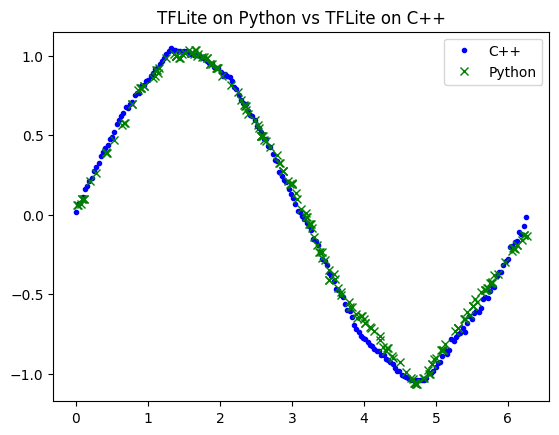

In [37]:
x_micro = []
y_micro = []
with open("result.txt") as f:
    lines = f.readlines()
    for line in lines:
        _s = line.index('x: ') + 3
        _e = line.index(',')
        x_micro.append(float(line[_s:_e]))
        _s = line.index('y: ') + 3
        _e = line.index('\n')
        y_micro.append(float(line[_s:_e]))
plt.clf()
plt.title('TFLite on Python vs TFLite on C++')
plt.plot(x_micro, y_micro, 'b.', label='C++')
plt.plot(x_test, y_test_pred_tflite, 'gx', label='Python')
plt.legend()
plt.show()

## 5. Cross Compile 하여 바이너리 실행 파일 생성

In [40]:
os.chdir('tensorflow')
!pwd
!make -f tensorflow/lite/micro/tools/make/Makefile TARGET=sparkfun_edge hello_world_bin
os.chdir('../')

/home/jangwon/tinyml/tensorflow
tensorflow/lite/micro/tools/make/downloads/flatbuffers already exists, skipping the download.
tensorflow/lite/micro/tools/make/downloads/pigweed already exists, skipping the download.
tensorflow/lite/micro/tools/make/downloads/gcc_embedded already exists, skipping the download.
tensorflow/lite/micro/tools/make/downloads/cmsis already exists, skipping the download.
tensorflow/lite/micro/tools/make/downloads/gcc_embedded/bin/arm-none-eabi-g++ -std=c++11 -fno-rtti -fno-exceptions -fno-threadsafe-statics -fno-unwind-tables -ffunction-sections -fdata-sections -fmessage-length=0 -DTF_LITE_STATIC_MEMORY -DTF_LITE_DISABLE_X86_NEON -O3 -Werror -Wsign-compare -Wdouble-promotion -Wshadow -Wunused-variable -Wmissing-field-initializers -Wunused-function -Wswitch -Wvla -Wall -Wextra -Wstrict-aliasing -Wno-unused-parameter -DSPARKFUN_EDGE -DPART_apollo3 -DAM_PACKAGE_BGA -DAM_PART_APOLLO3 -DGEMMLOWP_ALLOW_SLOW_SCALAR_FALLBACK -DTF_LITE_STATIC_MEMORY -DNDEBUG -DTF_LITE_M

/home/jangwon/tinyml/tensorflow/tensorflow/lite/micro/tools/make/downloads/gcc_embedded/bin/../lib/gcc/arm-none-eabi/10.2.1/thumb/v7e-m+fp/hard/libgcc.a
/home/jangwon/tinyml/tensorflow/tensorflow/lite/micro/tools/make/downloads/gcc_embedded/bin/../lib/gcc/arm-none-eabi/10.2.1/../../../../arm-none-eabi/lib/thumb/v7e-m+fp/hard/libm.a
/home/jangwon/tinyml/tensorflow/tensorflow/lite/micro/tools/make/downloads/gcc_embedded/bin/../lib/gcc/arm-none-eabi/10.2.1/../../../../arm-none-eabi/lib/thumb/v7e-m+fp/hard/libc_nano.a
/home/jangwon/tinyml/tensorflow/tensorflow/lite/micro/tools/make/downloads/gcc_embedded/bin/../lib/gcc/arm-none-eabi/10.2.1/thumb/v7e-m+fp/hard/libgcc.a
/home/jangwon/tinyml/tensorflow/tensorflow/lite/micro/tools/make/downloads/gcc_embedded/bin/../lib/gcc/arm-none-eabi/10.2.1/../../../../arm-none-eabi/lib/thumb/v7e-m+fp/hard/libstdc++_nano.a
/home/jangwon/tinyml/tensorflow/tensorflow/lite/micro/tools/make/downloads/gcc_embedded/bin/../lib/gcc/arm-none-eabi/10.2.1/../../../../

### 생성된 Target Device 바이너리 파일 확인

In [42]:
!ls tensorflow/tensorflow/lite/micro/tools/make/gen

linux_x86_64_default  sparkfun_edge.map  sparkfun_edge_cortex-m4_micro


In [44]:
!ls tensorflow/tensorflow/lite/micro/tools/make/gen/sparkfun_edge_cortex-m4_micro/bin

hello_world  hello_world.bin


### Cross Compile로 생성된 바이너리 파일은 Target Device가 아닌 플랫폼에서 실행 불가

In [45]:
!./tensorflow/tensorflow/lite/micro/tools/make/gen/sparkfun_edge_cortex-m4_micro/bin/hello_world

/bin/bash: 줄 1: ./tensorflow/tensorflow/lite/micro/tools/make/gen/sparkfun_edge_cortex-m4_micro/bin/hello_world: 이진 파일을 실행할 수 없음: Exec 형식 오류
